### Remake coordinates_bdy.nc file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

### Look at old boundary condition file coordinates

In [2]:
base_folder = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
old_coord = xr.open_dataset(f'{base_folder}eANT025-orig/coordinates_eANT025.L121.nc')
bdy_coord = xr.open_dataset(f'{base_folder}eANT025-orig/coordinates_bdy_eANT025.L121.nc')
bdy_file  = xr.open_dataset(f'{base_folder}eANT025-orig/bdyT_tra_y1979_eANT025.L121.nc')
bdyU_file = xr.open_dataset(f'{base_folder}eANT025-orig/bdyU_u3d_y1979_eANT025.L121.nc')
bdyV_file = xr.open_dataset(f'{base_folder}eANT025-orig/bdyV_u3d_y1979_eANT025.L121.nc')
mesh_mask = xr.open_dataset(f'{base_folder}eANT025-orig/mesh_mask_eANT025.L121.nc')

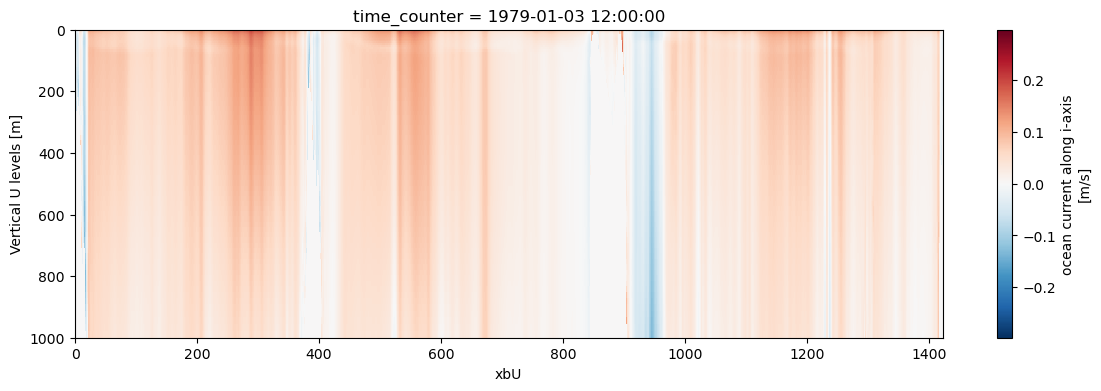

In [5]:
bdyU_file.vozocrtx.isel(time_counter=0,yb=0).plot(figsize=(14,4), ylim=(1000,0))

In [68]:
for var in ['e1t','e2t','gphit','glamt', 'nbit', 'nbjt', 'nbrt']:
    print(var, bdy_coord[var].min().values, bdy_coord[var].max().values)
print('---')
for var in ['e1v','e2v','gphiv','glamv', 'nbiv', 'nbjv', 'nbrv']:
    print(var, bdy_coord[var].min().values, bdy_coord[var].max().values)
print('---')
for var in ['e1u','e2u','gphiu','glamu', 'nbiu', 'nbju', 'nbru']:
    print(var, bdy_coord[var].min().values, bdy_coord[var].max().values)

e1t 16959.337890625 16959.337890625
e2t 16959.337890625 16959.337890625
gphit -52.40658950805664 -52.40658950805664
glamt -179.75 180.0
nbit 1 1440
nbjt 438 438
nbrt 1 1
---
e1v 16930.03125 16930.03125
e2v 16930.03125 16930.03125
gphiv -52.48278045654297 -52.48278045654297
glamv -179.75 180.0
nbiv 1 1440
nbjv 437 437
nbrv 1 1
---
e1u 16959.337890625 16959.337890625
e2u 16959.337890625 16959.337890625
gphiu -52.40658950805664 -52.40658950805664
glamu -179.875 179.875
nbiu 1 1440
nbju 438 438
nbru 1 1


(430.0, 438.5)

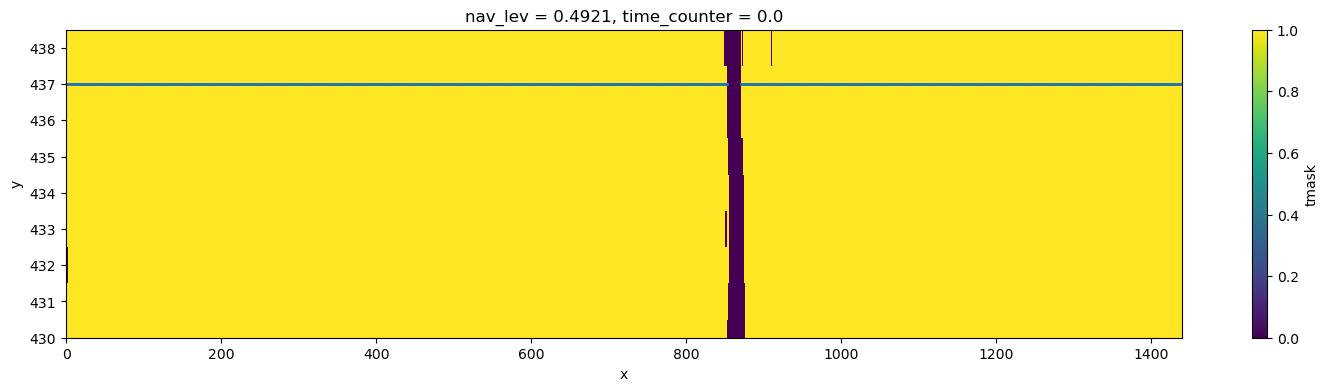

In [36]:
fig, ax = plt.subplots(1,1, figsize=(18,4))

mesh_mask.tmask.isel(time_counter=0, nav_lev=0).plot(ax=ax)
ax.scatter(bdy_coord.nbit.isel(yb=0)-1, bdy_coord.nbjt.isel(yb=0)-1, s=1)

ax.set_ylim(430,None)

(800.0, 900.0)

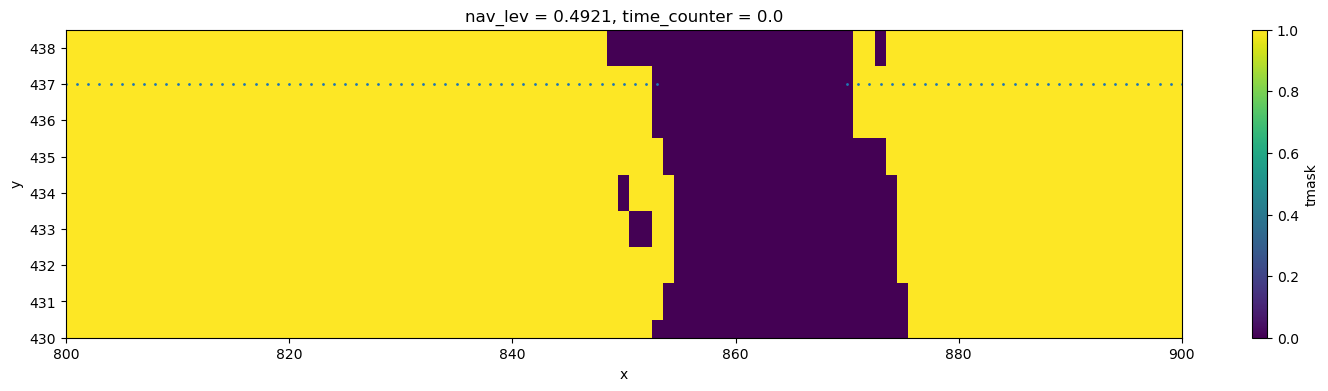

In [38]:
fig, ax = plt.subplots(1,1, figsize=(18,4))

mesh_mask.tmask.isel(time_counter=0, nav_lev=0).plot(ax=ax)
ax.scatter(bdy_coord.nbit.isel(yb=0)-1, bdy_coord.nbjt.isel(yb=0)-1, s=1)

ax.set_ylim(430,None)
ax.set_xlim(800,900)

(800.0, 900.0)

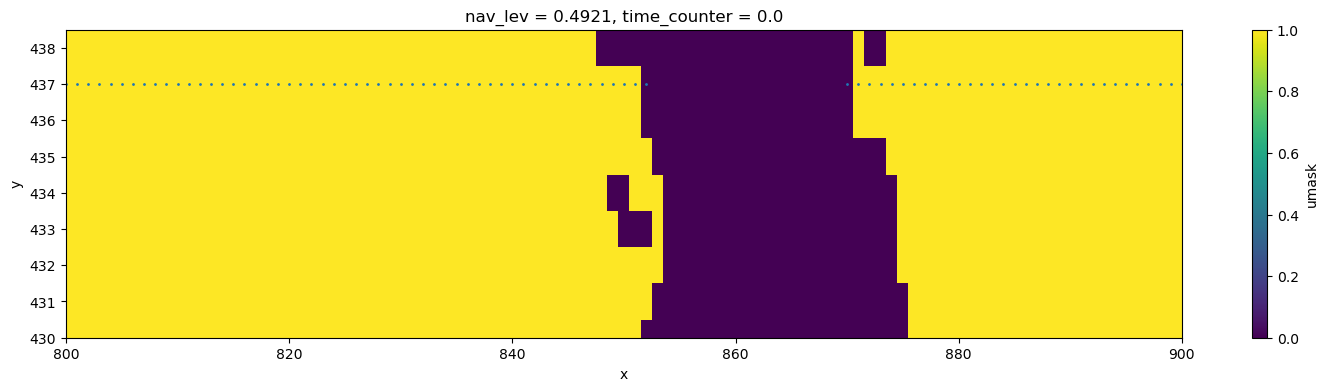

In [39]:
fig, ax = plt.subplots(1,1, figsize=(18,4))

mesh_mask.umask.isel(time_counter=0, nav_lev=0).plot(ax=ax)
ax.scatter(bdy_coord.nbiu.isel(yb=0)-1, bdy_coord.nbju.isel(yb=0)-1, s=1)

ax.set_ylim(430,None)
ax.set_xlim(800,900)

(800.0, 900.0)

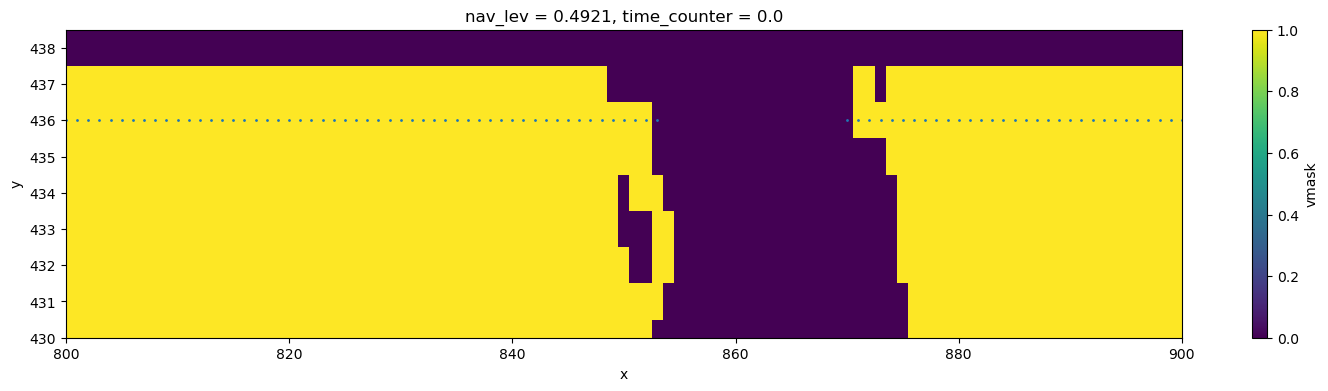

In [40]:
fig, ax = plt.subplots(1,1, figsize=(18,4))

mesh_mask.vmask.isel(time_counter=0, nav_lev=0).plot(ax=ax)
ax.scatter(bdy_coord.nbiv.isel(yb=0)-1, bdy_coord.nbjv.isel(yb=0)-1, s=1)

ax.set_ylim(430,None)
ax.set_xlim(800,900)

So in the coordinates_bdy file I need: yb=1, xbt=1440, xbv=1440, xbu=1440

T grid and U grid:
- e1t, e2t, gphit, glamt: (yb, xbt) values as in coordinates/meshmask file at python index 451
- nbit: np.arange(1,1441) (yb, xbt)
- nbjt: constant 452 (yb, xbt); fortran based indexing
- nbrt: constant 1 (yb, xbt)

V grid:
- e1v, e2v, gphiv, glamv: (yb, xbv) values as in coordinates/meshmask file at python index 450
- nbiv: np.arange(1,1441) (yb, xbv)
- nbjv: constant 451 (yb, xbv); fortran based indexing
- nbrv: constant 1 (yb, xbv)

#### Functions

In [125]:
np.expand_dims(np.arange(1,domain_cfg.x.size+1), axis=0).shape

(1, 1440)

In [114]:
domain_cfg.y.size

453

In [3]:
# Function makes a NEMO coordinate_bdy NetCDF file given input coordinates and a domain 
# Inputs:
# domain_cfg: xarray dataset of the domain_cfg NEMO file
# filename: string of output file name / location
# Returns: xarray dataset containing the variables required to specify the boundary in the NEMO namelist
def northern_bdy_coord(domain_file='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc',
                       filename='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetery/coordinates_bdy-test.nc'):

    # index of northern boundary condition
    domain_cfg  = xr.open_dataset(f'{domain_file}').isel(time_counter=0, nav_lev=0).rename({'y':'yb'}).drop_vars(['time_counter','nav_lev'])
    bdy_ind     = domain_cfg.yb.size-1 # python based indexing
    domain_cfgT = domain_cfg.rename({'x':'xbt'}).isel(yb=slice(bdy_ind,bdy_ind+1))
    domain_cfgU = domain_cfg.rename({'x':'xbu'}).isel(yb=slice(bdy_ind,bdy_ind+1))
    domain_cfgV = domain_cfg.rename({'x':'xbv'}).isel(yb=slice(bdy_ind-1,bdy_ind))
    
    # Create xarray dataset:
    ds = xr.Dataset(
        data_vars=dict(
                    e1t=domain_cfgT['e1t'],
                    e1u=domain_cfgU['e1u'], 
                    e1v=domain_cfgV['e1v'], 
                    e2t=domain_cfgT['e2t'],
                    e2u=domain_cfgU['e2u'],
                    e2v=domain_cfgV['e2v'],
                    glamt=domain_cfgT['glamt'],
                    glamu=domain_cfgU['glamu'],
                    glamv=domain_cfgV['glamv'],
                    gphit=domain_cfgT['gphit'],
                    gphiu=domain_cfgU['gphiu'],
                    gphiv=domain_cfgV['gphiv'],
                    nbit=(["yb", "xbt"], np.expand_dims(np.arange(1,domain_cfgT.xbt.size+1), axis=0)),
                    nbiu=(["yb", "xbu"], np.expand_dims(np.arange(1,domain_cfgU.xbu.size+1), axis=0)),
                    nbiv=(["yb", "xbv"], np.expand_dims(np.arange(1,domain_cfgV.xbv.size+1), axis=0)),
                    nbjt=(["yb", "xbt"], (np.ones((1,domain_cfgT.xbt.size))*bdy_ind).astype('int')),
                    nbju=(["yb", "xbu"], (np.ones((1,domain_cfgU.xbu.size))*bdy_ind).astype('int')),
                    nbjv=(["yb", "xbv"], (np.ones((1,domain_cfgV.xbv.size))*(bdy_ind-1)).astype('int')),
                    nbrt=(["yb", "xbt"], (np.ones((1,domain_cfgT.xbt.size))).astype('int')),
                    nbru=(["yb", "xbu"], (np.ones((1,domain_cfgU.xbu.size))).astype('int')),
                    nbrv=(["yb", "xbv"], (np.ones((1,domain_cfgV.xbv.size))).astype('int')),
        ),
        attrs=dict(description="Boundary condition coordinates file"),
    )    
    
    ds.to_netcdf(f'{filename}')


    return ds

### Read files

In [5]:
ds_coord = northern_bdy_coord(filename='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/coordinates_bdy-test8.nc')